# Classifier 1
This classifier works by first training the model on MNIST data (from the Keras MNIST dataset). The AddNIST images are then split by colour channel into three separate images (each containing an individual digit). The final value is given by summing the output of three inference runs of the model (each on one of the individual digits) - 1. This is then compared to the labels for the original AddNIST image for evaluation.

### Connect to Google Drive to retrieve data
You can use the below cell to connect to your own google drive, if that is where you are storing the addNIST data you want to use for this notebook. If you are using data stored locally, leave this cell commented out.

In [ ]:
# to access google drive folder
# from google.colab import drive
# drive.mount('/content/drive') # When you run this you'll be prompted for a token - follow the link to generate this.

## Importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow

### Load data

In [ ]:
import numpy as np

train_x = np.load("data/MNP/train_x.npy", allow_pickle=True)

# Alternative file-path for use with Google Drive, if that is where you have stored your AddNIST data
#train_x = np.load("/content/drive/MyDrive/data/MNP/train_x.npy", allow_pickle=True)

In [ ]:
train_y = np.load("data/MNP/train_y.npy", allow_pickle=True)

# Alternative file-path for use with Google Drive, if that is where you have stored your AddNIST data
#train_y = np.load("/content/drive/MyDrive/data/MNP/train_y.npy", allow_pickle=True)

In [ ]:
validate_x = np.load("data/MNP/valid_x.npy", allow_pickle=True)

# Alternative file-path for use with Google Drive, if that is where you have stored your AddNIST data
#validate_x = np.load("/content/drive/MyDrive/data/MNP/valid_x.npy", allow_pickle=True)

In [ ]:
validate_y = np.load("data/MNP/valid_y.npy", allow_pickle=True)

# Alternative file-path for use with Google Drive, if that is where you have stored your AddNIST data
#validate_y = np.load("/content/drive/MyDrive/data/MNP/valid_y.npy", allow_pickle=True)

In [ ]:
test_x = np.load("data/MNP/test_x.npy", allow_pickle=True)

# Alternative file-path for use with Google Drive, if that is where you have stored your AddNIST data
#test_x = np.load("/content/drive/MyDrive/data/MNP/test_x.npy", allow_pickle=True)

In [ ]:
test_y = np.load("data/MNP/test_y.npy", allow_pickle=True)

# Alternative file-path for use with Google Drive, if that is where you have stored your AddNIST data
#test_y = np.load("/content/drive/MyDrive/data/MNP/test_y.npy", allow_pickle=True)

#### Import Keras MNIST data

This data will be used for initial training of the model in this notebook; before the model is deployed on the AddNIST dataset

In [ ]:
# the data, split between train and validate sets
(MNIST_train_x, MNIST_train_y), (MNIST_test_x, MNIST_test_y) = tensorflow.keras.datasets.mnist.load_data()

### Check the shape of the data

You can do this for all data files

In [ ]:
print("MNIST_train_x shape:", MNIST_train_x.shape)
print("MNIST_test_x shape:", MNIST_test_x.shape)
print("test_x shape:", test_x.shape)

### Define number of classes and input shape to be used by the model

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

### Convert ground-truth label data into catagorical (One-hot-encoding) data

In [ ]:
# convert class vectors to one-hot-encoding
MNIST_train_y = keras.utils.to_categorical(MNIST_train_y, num_classes)
MNIST_test_y = keras.utils.to_categorical(MNIST_test_y, num_classes)
test_y = keras.utils.to_categorical(test_y, 20)

### Normalise image data into [0, 1] range

In [ ]:
# Scale images to the [0, 1] range
MNIST_train_x = MNIST_train_x.astype("float32") / 255
MNIST_test_x = MNIST_test_x.astype("float32") / 255

In [ ]:
# Make sure images have shape (28, 28, 1)
MNIST_train_x = np.expand_dims(MNIST_train_x, -1)
MNIST_test_x = np.expand_dims(MNIST_test_x, -1)

print("MNIST_train_x shape:", MNIST_train_x.shape)
print("MNIST_test_x shape:", MNIST_test_x.shape)
print("test_x shape:", test_x.shape)

### Define the model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) # Input layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # Output layer

model.summary()

### Define callbacks
I have made use of Keras' callback api to define callbacks which will stop training when:
1. There is a plateau in the increase in validation accuracy gained between epochs (e.g., if there has been no increase in val_accuracy after 5 epochs (compared to the max val_accuracy seen in any epoch so far)

I have set `restore_best_weights = True`. This means that when the training 'early-stops', it will reset its weights back to the 'best' epoch seens so far.
> Best, being defined here as either lowest val_loss or highest val_accuracy, depending upon which callback is triggered

In [ ]:
from keras import callbacks
earlystopping_acc = callbacks.EarlyStopping(monitor ="val_accuracy", mode ="max", patience = 6, restore_best_weights = True)

### Compile and train the model



In [ ]:
batch_size = 200
epochs = 25

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "Precision", "Recall"])

history = model.fit(MNIST_train_x, MNIST_train_y, batch_size=batch_size, epochs=epochs, validation_data=(MNIST_test_x, MNIST_test_y), callbacks=[earlystopping_acc])

### Save the trained model

In [ ]:
model.save("models/task-1/Task-1-model")

### Define function to will split each image 
Splits each image in the addNIST dataset into three images; one for each RGB colour channel

In [ ]:
# Split image into three images, separateed by RGB colour channel
def split(test_x):
  red_images = []
  blue_images = []
  green_images = []

  for x in test_x:
    subimage = x.copy()

    red_images.append(np.expand_dims(subimage[0], 2))

    blue_images.append(np.expand_dims(subimage[1], 2))

    green_images.append(np.expand_dims(subimage[2], 2))

  return [red_images, green_images, blue_images]   

Split images and make predictions based on the prediction of each colour channel's image

In [ ]:
# Split images
split_images = split(test_x)

# Format images split into separate RGB channels into NumPy arrays
red_imgs = np.array(split_images[0])
green_imgs = np.array(split_images[1])
blue_imgs = np.array(split_images[2])

# Make predictions for each set of images
red_y_preds = model.predict(red_imgs)
green_y_preds = model.predict(green_imgs)
blue_y_preds = model.predict(blue_imgs)

predictions = []

# Sum the predictions from each colour channel, subtract 1, and add the results as the prediction to be compared against addNIST ground truth label
for i in range(len(red_y_preds)):
  predictions.append((np.argmax(red_y_preds[i]) + np.argmax(green_y_preds[i]) + np.argmax(blue_y_preds[i]) - 1))

predictions = np.array(predictions)

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [ ]:
accuracy = metrics.accuracy_score(np.argmax(test_y, axis=1), predictions)
precision = metrics.precision_score(np.argmax(test_y, axis=1), predictions, average="micro")
recal = metrics.recall_score(np.argmax(test_y, axis=1), predictions, average="micro")
f1 = metrics.f1_score(np.argmax(test_y, axis=1), predictions, average="micro")
print("Accuracy score for AddNIST test data:", accuracy)
print("Precision score for AddNIST test data:", precision)
print("Recal score for AddNIST test data:", recal)
print("F1 score for AddNIST test data:", f1)

## Visualise the training and validation results

### Visualise comparison of loss in training data and in validation data for each epoch in training

In [ ]:
# Plot training and validation loss
# Code taken from CSC3138 Practical2a.ipynb
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

def plot_training_loss(history_dict):
  plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss') # blue dots
  plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss') # blue line
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

plot_training_loss(history_dict)

### Visualise comparison of accuracy in training data and in validation data for each epoch in training

In [ ]:
# Plot training and validation accuracy
# Code taken from CSC3138 Practical2a.ipynb
def plot_training_accuracy(history_dict):
  plt.clf()
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

plot_training_accuracy(history_dict)

### Visualise results in a confusion matrix
Matrix plots predictions from test data, against ground truth labels

In [ ]:
# Function to plot the confusion matrix:
def plot_confusion_matrix(gt, pred, classes=0, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    cm = metrics.confusion_matrix(gt, pred, labels=classes)
    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, fontsize=7)
    plt.yticks(tick_marks, fontsize=7)

    plt.grid(True)

    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')
    plt.tight_layout()
    plt.savefig(f"cm.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# Plot confusion matrix with 20 classes from addNIST
plot_confusion_matrix(np.argmax(test_y, axis=1), predictions, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], normalize=False)

Output from the below cell shows predictions where the prediction is outside of the 20 pre-defined classes for the addNIST dataset (0 - 19), e.g. the prediction is >= 20. This has been excluded from the confusion matrix to ensure clarity of that chart, and are instead shown below to ensure they are visible.

In [ ]:
for i in range(len(predictions)):
  if predictions[i] > 19:
    print(f"Prediction: {predictions[i]}  |  Ground truth: {np.argmax(test_y, axis=1)[i]}")

# Report

# Creating a Convolutional Neural Network Classifier for the addNIST Dataset
## Introduction
The aim of this report is to examine the effectiveness of the novel convolutional neural network created in this notebook when it is deployed as a classifier for the addNIST dataset.

## Background
The addNISt dataset is a dataset comprising of three 'hand-written' digits from the MNIST library, overlayed on top of each other, separated by the three RGB colour channels (Red, Green, Blue). These images each have a label that equals the sum of the three numbers within the image, minus 1.

The MNIST library is a library of grey-scale images containing 'hand-written' digits in the range 0-9. These images have a label equal to the digit displayed in the image.

The purpose of the model in this notebook is for it to work as an effective classifier of samples within the addNIST dataset. The model will first be trained using the MNIST library. Then, the RGB images within the addNIST library will each be split into three images (one for each colour channel). The model will then predict the values of the individual digits contained within the split-out images. Final classification will be given to the original addNIST samples using the formula `red_image-prediction + gree_image_prediction + blue_image_prediction - 1)`.

## The model
The model is a Convolutional Neural Network made up primarily of three sets of 2 Convolutional layers, 1 Max-pooling layer and 1 dropout layer; followed by one fully-connected dense layer, a final Dropout layer and a dense layer with softmax activation for final classification. The model is shown in Figure-1.

Convolution layers have been used due to the power of convolution layers
learn 'local' patterns within images; making them the obvious choice for image classification models.

Dropout has been used to moderate overfitting, by dropping out some of the output features from the previous layers. This helps increase the generalisation of the model's inference, and thus reduces overfitting.

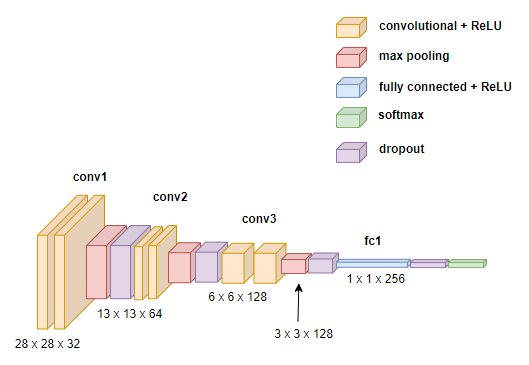

*Figure 1*


## Data preparation
For y-value ground-truth labels, the labels have been formatted into categorical, One-Hot-Encoding format.

The MNIST dataset has been normalised to values between [0, 1].

The addNIST dataset has been split by colour channel. Thus, each addNIST image has been split into three images, one for each of the RGB (Red, Green, Blue) colour channels.

## Training
The model was trained using the MNIST 'training' dataset, and the MNIST 'test' dataset was used for validation during the training process.
A batch size of 200 has been used because it offered the best accuracy results after comparisons of batch sizes ranging from 30 to 300.
Keras' Callbacks API has been used to implement "early stopping", which will stop training if there is a plateau in the increase of validation accuracy score. When early stopping is invoked, the weights of the best epoch are reset on the model. This, to some extent, automates finding the optimum number of epochs. The number of epochs has been explicitly set at 25; this has been done to allow appropriate 'room' for early stopping to be invoked before the last epoch, to allow selection of the 'best' epoch, which commonly occurs between epoch 7  and 16.

The training performance of the model can be seen in the chart outputs of cells 23 and 24; chart outputs from last run are displayed in Figure 2 and Figure 3. The use of both dropout layers and callback optimisation of the number of epochs appears to have minimised overfitting to a good degree.
The final model was then evaluated using the split addNIST images, original images coming from the addNIST 'test' dataset.

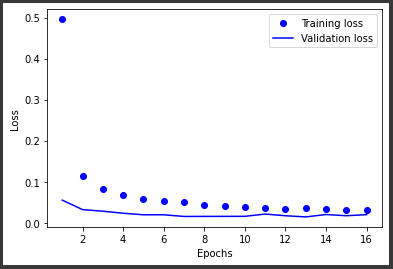

_Figure 2 - Training and validation loss from last run_

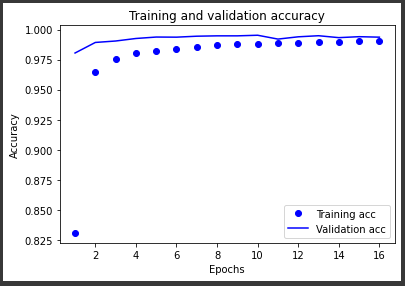

_Figure 3 - Training and validation accuracy scores from last run_

## Results
The model provided the following results when used to predict on the addNIST test data:

- Accuracy score for AddNIST test data: 0.9898 (98.98%)

Accuracy ranges slightly run-to-run in the range of: 97.6% - 98.9%

## Evaluating the results
Accuracy was picked as the metric of success for this model because it is often one of the best metrics of success for a classification model where there is a good distribution of data across the different classes, as is the case for the addNIST dataset.
Given the accuracy provided, we can say that the model provides an effective means of classifying the addNIST dataset. Given that the model's prediction accuracy approaches 100%. However, improvements are likely possible but could not be found during the development of this notebook.

## Conclusion
Splitting out the addNIST images into three separate  images and passing them through a network trained on the MNIST dataset is a valid and effective way to classify data in the addNIST dataset. Furthermore, the model in this notebook has been effective in doing exactly that.
